In [2]:
import torch
from torch import nn,optim
import torchvision
import d2l_pytorch as d2l
import time

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from functools import partial

In [4]:
def multiply(x,y):
        return x * y

# create a new function that multiplies by 2
dbl = partial(multiply,2)
print(dbl(4))

8


In [5]:
def init_weights(m):
    if type(m)==nn.Linear or type(m)==nn.Conv2d:
        torch.nn.init.normal_(m.weights,mean=0,std=0.01)
        m.bias.data.full_(0)

In [6]:
class ZFNet(nn.Module):
    def __init__(self,num_classes):
        super(ZFNet,self).__init__()
        self.features=nn.Sequential(
            # layer 1
            nn.Conv2d(1,96,kernel_size=7,stride=2,padding=1),
            nn.ReLU(inplace=True),
            # return_indices=True，返回最大值所在的索引，及其值
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1,return_indices=True),
            # layer 2
            nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1,return_indices=True),
            # layer 3
            nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            # layer 4
            nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            # layer 5
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,return_indices=True)
        )
        self.flatten=d2l.FlattenLayer()
        self.classifier=nn.Sequential(
            # layer 6
            nn.Linear(in_features=6*6*256,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            # layer 7
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            # layer 8
            nn.Linear(in_features=4096,out_features=num_classes)
        )
        # 在定义forward()之前，声明保存特征图的函数
        self.feature_maps=dict()
        self.pool_locs=dict()
        self.store()
    # 参数初始化
    def init_weights(self):
        def init_function(m):
            if type(m) == nn.Linear or type(m) == nn.Conv2d:
                torch.nn.init.normal_(m.weight, mean=0, std=0.01)
                m.bias.data.fill_(0)    
        _ = self.apply(init_function)
    
    # 定义函数
    def store(self):
        def hook(module,input,output,key):
            if isinstance(module,nn.MaxPool2d):
                self.feature_maps[key]=output[0]
                self.pool_locs=output[1]
            else:
                self.feature_maps[key]=output
        for idx,layer in enumerate(self.features):
            # register_forward_hook()函数必须在forward（）函数调用之前被使用，
            # hook的作用是通过系统来维护一个链表，使得用户拦截（获取）通信消息，用于处理事件。
            # pytorch中包含forward和backward两个hook注册函数，用于获取forward和backward中输入和输出
            layer.register_forward_hook(partial(hook,key=idx))

    # forward
    def forward(self,x):
        # 重置
        self.feature_maps = dict()
        self.pool_locs = dict()
        # return_indices=True的池化层，会返回一个元组，
        # farword中，只需要第一个
        for idx, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, _ = layer(x)
            else:
                x = layer(x)
        x=self.flatten(x)          
        x=self.classifier(x.view(-1,6*6*256))
        return x

class ZFNet(nn.Module):
    def __init__(self,num_classes):
        super(ZFNet,self).__init__()
        self.layer1=nn.Sequential(
            # layer 1
            nn.Conv2d(1,96,kernel_size=7,stride=2,padding=1),
            nn.ReLU(inplace=True),
            # return_indices=True，返回最大值所在的索引，及其值
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1,return_indices=True))
        self.layer2=nn.Sequential(
            # layer 2
            nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1,return_indices=True))
        self.layer3=nn.Sequential(
            # layer 3
            nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True))
        self.layer4=nn.Sequential(
            # layer 4
            nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True))
        self.layer5=nn.Sequential(
            # layer 5
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,return_indices=True))
        self.flatten=d2l.FlattenLayer()
        self.classifier=nn.Sequential(
            # layer 6
            nn.Linear(in_features=6*6*256,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            # layer 7
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            # layer 8
            nn.Linear(in_features=4096,out_features=num_classes))
    # forward
    def forward(self,x):
        # return_indices=True的池化层，会返回一个元组，
        # farword中，只需要第一个
        
        x,_=self.layer1(x)
        x,_=self.layer2(x)
        x,_=self.layer5(self.layer4(self.layer3(x)))
        x=self.flatten(x)
        x=self.classifier(x)
        return x

In [7]:
num_classes=10
net=ZFNet(num_classes)

In [8]:
print(net)

ZFNet(
  (features): Sequential(
    (0): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): FlattenLayer()
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(

In [9]:
# print(net)
# test

x=torch.randn(1,1,224,224)
for name,blk in net.named_children():
    print(type(blk))
print(net(x))

<class 'torch.nn.modules.container.Sequential'>
<class 'd2l_pytorch.FlattenLayer'>
<class 'torch.nn.modules.container.Sequential'>
tensor([[ 0.0120,  0.0005, -0.0044,  0.0108,  0.0057,  0.0067,  0.0037, -0.0195,
          0.0040,  0.0082]], grad_fn=<AddmmBackward>)


In [10]:

pretrained_weights = None

# 设置超参数
batch_size=128

lr,num_epochs=0.002,5

optimizer=torch.optim.Adam(net.parameters(),lr=lr) 

# 损失函数，使用交叉熵损失函数
loss=torch.nn.CrossEntropyLoss()

if pretrained_weights != None:
    net.load_state_dict(torch.load(pretrained_weights))
else:
    net.init_weights()

In [18]:
train_iter,test_iter=d2l.load_data_fashion_mnist_resize(batch_size,resize=227)

In [11]:
import numpy as np 


train_loss_list = list()
train_accuracy_list = list()
test_loss_list = list()
test_accuracy_list = list()

In [16]:

net=net.to(device)
print('training on ',device)
 
for epoch in range(num_epochs):
    start=time.time()
    
    net.train()
    
    train_l_sum,train_acc_sum,n,batch_count=0.0,0.0,0,0
    
    for i,(X,y) in enumerate(train_iter):
        X=X.to(device)
        y=y.to(device)
        y_hat=net(X)
        # 计算损失
        l=loss(y_hat,y)
        # 梯度清零
        optimizer.zero_grad()
        # 反向传播
        l.backward()
        # 更新参数
        optimizer.step()
        print('epoch %d/%d, iter %d/391, loss %.3f' % (epoch,num_epochs,i,l.cpu().item()))
        if (i+1) % 10 == 0:
            # print('epoch %d/%d, iter %d/391, loss %.3f' % (epoch,num_epochs,i,l.cpu().item()))
            print('label(GT):',y[:10].numpy())
            print('label(PD):',np.argmax(y_hat.cpu().data.numpy()[:10], axis=1))
        
        # 更新损失和正确率
        train_l_sum+=l.cpu().item()
        train_acc_sum+=(y_hat.argmax(dim=1) == y ).sum().cpu().item()
        n+=y.shape[0]
        batch_count+=1

        if (i+1) % 5==0:
            break

    # 计算train_loss, train_acc,test_acc
    train_loss=train_l_sum/batch_count
    train_acc=train_acc_sum/n
    # 测试集上的正确率
    test_acc,test_loss=d2l.eval_acc_loss(test_iter,net,loss)
    
    # acc,loss图
    print('epoch:',epoch+1, 'train loss %.2f' % (train_loss), 'train acc %.3f%%' % (train_acc*100), 'test loss %.2f' % (test_loss), 'test acc %.3f%%' % (test_acc*100))
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)
    test_loss_list.append(test_loss)
    print('epoch',epoch, 'time elapsed %.1f'%(time.time()-start) )
    
    # save weights
    if not os.path.isdir('./weights'):
        os.mkdir('weights')
    torch.save(net.state_dict(), './weights/pretrained_weights_{}.pth'.format(epoch+1))

training on  cpu
epoch 0/5, iter 0/391, loss 2.308
epoch 0/5, iter 1/391, loss 2.295
epoch 0/5, iter 2/391, loss 5.871
epoch 0/5, iter 3/391, loss 2.334
epoch 0/5, iter 4/391, loss 2.261
epoch: 1 train loss 3.01 train acc 11.719% test acc 11.250%
epoch 0 time elapsed 55.1
epoch 1/5, iter 0/391, loss 2.275
epoch 1/5, iter 1/391, loss 2.205
epoch 1/5, iter 2/391, loss 2.107
epoch 1/5, iter 3/391, loss 2.195
epoch 1/5, iter 4/391, loss 2.296
epoch: 2 train loss 2.22 train acc 13.438% test acc 16.406%
epoch 1 time elapsed 54.6
epoch 2/5, iter 0/391, loss 2.277
epoch 2/5, iter 1/391, loss 2.226
epoch 2/5, iter 2/391, loss 2.103
epoch 2/5, iter 3/391, loss 1.893
epoch 2/5, iter 4/391, loss 1.714
epoch: 3 train loss 2.04 train acc 21.562% test acc 36.875%
epoch 2 time elapsed 54.3
epoch 3/5, iter 0/391, loss 1.778
epoch 3/5, iter 1/391, loss 1.443
epoch 3/5, iter 2/391, loss 1.402
epoch 3/5, iter 3/391, loss 1.461
epoch 3/5, iter 4/391, loss 1.522
epoch: 4 train loss 1.52 train acc 39.531% te

In [12]:
import matplotlib.pyplot as plt

In [ ]:
x = np.arange(len(train_accuracy_list) + 1)
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.plot(x, [0] + train_accuracy_list)
plt.plot(x, [0] + test_accuracy_list)
plt.legend(['training accuracy', 'testing accuracy'], loc='upper right')
plt.grid(True)
plt.savefig('Accuracy_numCls{}_epoch{}.png'.format(num_classes, epoch+1)) 
plt.show()

In [ ]:
# plt.xlabel('epochs')
# plt.ylabel('Loss')
# plt.plot(x, train_loss_list[0:1] + train_loss_list)
# # plt.plot(x, train_loss_list[0:1] + test_loss_list)
# plt.legend(['training loss', 'testing loss'], loc='upper right')
# plt.savefig('Loss_numCls{}_epoch{}.png'.format(num_classes, epoch+1))
# plt.show() 

In [14]:
class D_ZFNet(nn.Module):
    def __init__(self,ZFNet):
        super(D_ZFNet,self).__init__()
        # 这个list保存每个网络层的输出
        self.layer=list()
        # 遍历网络前5个卷积层,如果是卷积层，则使用反卷积解构，
        # 如果是激活层或最大池化层，则保持不变
        for i,layer in enumerate(ZFNet.features):
            if isinstance(layer,nn.Conv2d):
                self.layer.append(nn.ConvTranspose2d(layer.out_channels,layer.in_channels,layer.kernel_size,layer.stride,layer.padding,bias=False))
                self.layer[i].weight.data=layer.weight.data
            elif isinstance(layer,nn.ReLU):
                self.layer.append(nn.ReLU(inplace=True))
            elif isinstance(layer,nn.MaxPool2d):
                self.layer.append(nn.MaxPool2d(layer.kernel_size,layer.stride,layer.padding))
            else:
                self.layer.append(None)
    
    def forward(self,x,idxs,ZFNet):
        if not 0<=idxs < len(self.layer):
            raise ValueError('idxs value out of range')
        # 逆序遍历，从后往前遍历网络
        for idx in range(idxs,-1,-1):
            if isinstance(self.layer[idx],nn.MaxPool2d):
                x=self.layer[idx](x, ZFNet.pool_locs[idx], net.feature_maps[idx-1].shape)
            elif self.layer[idx]==None:
                continue
            else:
                x=self.layer[idx](x)
        return x

In [15]:
pretrained_weights='./weights/pretrained_weights_5.pth'
# if pretrained_weights != None:
#     net.load_state_dict(torch.load(pretrained_weights))
# else:
#     _ = net.apply(init_weights)    
net.load_state_dict(torch.load(pretrained_weights))

<All keys matched successfully>

In [16]:
d_net=D_ZFNet(net)

In [19]:
img,label=iter(test_iter).next()
x=img[:1]
y=label[:1]
print(x.shape)

torch.Size([1, 1, 227, 227])


In [20]:
orig_img=x.view((227, 227)).numpy()
orig_img.shape

(227, 227)

In [21]:
print(y)

tensor([9])


In [22]:
net.eval()
d_net.eval()

D_ZFNet()

使用另外一张图片，进行测试

In [23]:
with torch.no_grad():
    conv_output=net(x)

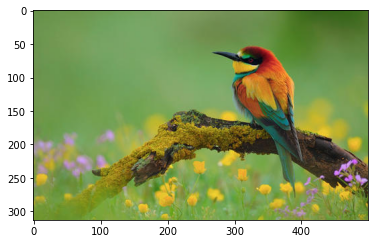

<class 'numpy.ndarray'>


In [24]:

from matplotlib import image as mpimg

img1 = mpimg.imread('./img.jpg')
plt.imshow(img1)
plt.show()  
print(type(img1))

D:\application\anaconda\envs\pytorch\lib\site-packages\torchvision\transforms\transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


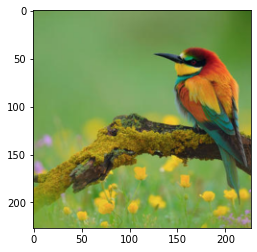

In [25]:
from PIL import Image
import torchvision.transforms as transforms


def readImage(path='./img.jpg', size=227):
    mode = Image.open(path)
    transform1 = transforms.Compose([
        transforms.Scale(size),
        transforms.CenterCrop((size, size)),
        transforms.ToTensor()
    ])
    mode = transform1(mode)
    return mode


def showTorchImage(image):
    mode = transforms.ToPILImage()(image)
    plt.imshow(mode)
    plt.show()

mode = readImage(size=227)
showTorchImage(mode)


In [26]:
from IPython import display
display.set_matplotlib_formats('svg')

In [27]:
print(mode.shape)
tmp=mode[0,:,:]
tmp.reshape(1,227,227)
tmp.shape

torch.Size([3, 227, 227])


torch.Size([227, 227])

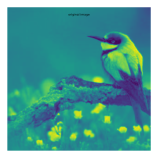

In [28]:
plt.figure(figsize=(15, 9), dpi=300)
plt.subplot(3, 5, 1)
plt.title('original image', y=0.9, fontsize=3)
plt.axis('off')
# plt.imshow(orig_img)
plt.imshow(tmp)

In [37]:

tmp = np.expand_dims(tmp, axis=0)
tmp.shape

(1, 227, 227)

In [40]:

tmp = np.expand_dims(tmp, axis=0)
tmp.shape

(1, 1, 227, 227)

In [41]:
t=torch.from_numpy(tmp)
t.shape

torch.Size([1, 1, 227, 227])

In [42]:
with torch.no_grad():
    conv_output=net(t)

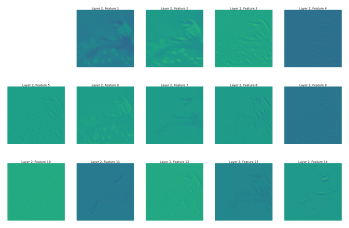

In [44]:
idx_layer = 1
feature_maps = net.feature_maps[idx_layer]
feature_sort = torch.argsort(torch.sum(feature_maps[0], axis=(-1, -2)), descending=True)

for idx_feature in range(14):
    feature_map = torch.zeros(feature_maps.shape).cpu()
    feature_map[0, feature_sort[idx_feature]] = feature_maps[0, feature_sort[idx_feature]]
    with torch.no_grad():
        img_ = d_net(feature_map, idx_layer, net)
    img_ = img_.cpu().numpy()[0].transpose(1, 2, 0)
    img_ = (img_ - img_.min()) / (img_.max() - img_.min()) * 255.
    img_ = img_.astype(np.uint8)
    plt.subplot(3 , 5, idx_feature+2)
    plt.title('Layer {}, Feature {}'.format(idx_layer+1, idx_feature+1), y=0.9, fontsize=3)
    plt.axis('off')
    plt.imshow(img_)
plt.savefig('feature_visualization_sameLayer.jpg')
plt.show()